In [1]:
from torchvision import datasets
import torchvision.transforms as transforms

import numpy as np
import torch
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def load_data(n_workers, batch_size, data, path):
  img_resize = 64

  transform = transforms.Compose([transforms.Resize(img_resize), transforms.ToTensor()])

  if data == 'MNIST':
    train_data = datasets.MNIST(root=path, train=True, download=True, transform=transform)
  if data == 'FashionMNIST':
    train_data = datasets.FashionMNIST(root=path, train=True, download=True, transform=transform) 

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers = n_workers)

  return train_loader

In [3]:
def check_load_data(train_loader, start_ind, end_ind):
  dataiter = iter(train_loader)
  images, _ = dataiter.next()
  images = images.numpy()
  for i in (start_ind, end_ind, 1):
    img = np.squeeze(images[i])
    fig = plt.figure(figsize = (3,3)) 
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')  

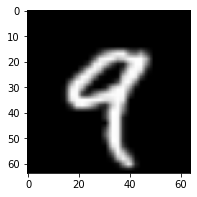

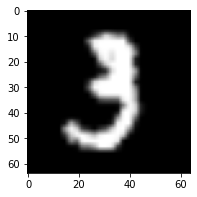

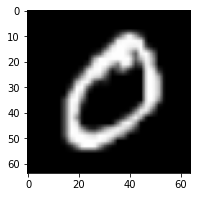

In [4]:
MNIST_data = load_data(0, 64, 'MNIST', 'mnist')
check_load_data(MNIST_data, 4, 10)

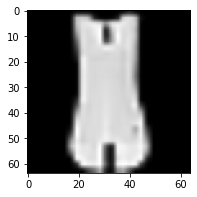

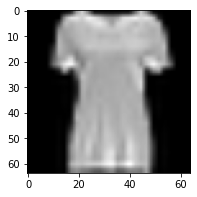

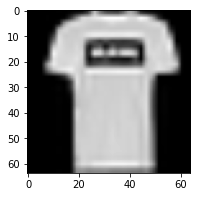

In [5]:
FashionMNIST_data = load_data(0, 64, 'FashionMNIST', 'fashion_mnist')
check_load_data(FashionMNIST_data, 4, 10)

In [6]:
class Discriminator(nn.Module):
    def __init__(self, input, n_features, output):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = input, out_channels = n_features, kernel_size=4, stride=2, padding=1)   
        self.conv2 = nn.Conv2d(in_channels = n_features, out_channels = n_features*2, kernel_size=4, stride=2, padding=1) 
        self.conv3 = nn.Conv2d(in_channels = n_features*2, out_channels = n_features*4, kernel_size=4, stride=2, padding=1)        
        self.conv4 = nn.Conv2d(in_channels = n_features*4, out_channels = n_features*8, kernel_size=4, stride=2, padding=1) 
        self.conv5 = nn.Conv2d(in_channels = n_features*8, out_channels = output, kernel_size=4, stride=1, padding=0)

        self.batchnorm1 = nn.BatchNorm2d(num_features = n_features)
        self.batchnorm2 = nn.BatchNorm2d(num_features = n_features*2)
        self.batchnorm3 = nn.BatchNorm2d(num_features = n_features*4)
        self.batchnorm4 = nn.BatchNorm2d(num_features = n_features*8)

        self.leaky_relu = nn.LeakyReLU(0.2)
        
    def forward(self, x):

        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.leaky_relu(out)

        out = self.conv2(out)
        out = self.batchnorm2(out)
        out = self.leaky_relu(out)

        out = self.conv3(out)
        out = self.batchnorm3(out)
        out = self.leaky_relu(out)

        out = self.conv4(out)
        out = self.batchnorm4(out)
        out = self.leaky_relu(out)

        out = self.conv5(out)
        
        return out

In [7]:
class Generator(nn.Module):
    def __init__(self, input, n_features, output):
        super(Generator, self).__init__()

        self.convT1 = nn.ConvTranspose2d(in_channels = input, out_channels = n_features*16, kernel_size=4, stride=1, padding=0)      
        self.convT2 = nn.ConvTranspose2d(in_channels = n_features*16, out_channels = n_features*8, kernel_size=4, stride=2, padding=1)
        self.convT3 = nn.ConvTranspose2d(in_channels = n_features*8, out_channels = n_features*4, kernel_size=4, stride=2, padding=1)
        self.convT4 = nn.ConvTranspose2d(in_channels = n_features*4, out_channels = n_features*2, kernel_size=4, stride=2, padding=1)
        self.convT5 = nn.ConvTranspose2d(in_channels = n_features*2, out_channels = output, kernel_size=4, stride=2, padding=1)
        
        self.batchnorm1 = nn.BatchNorm2d(num_features=n_features*16)
        self.batchnorm2 = nn.BatchNorm2d(num_features=n_features*8)
        self.batchnorm3 = nn.BatchNorm2d(num_features=n_features*4)
        self.batchnorm4 = nn.BatchNorm2d(num_features=n_features*2)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.convT1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)

        x = self.convT2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)

        x = self.convT3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)

        x = self.convT4(x)
        x = self.batchnorm4(x)
        x = self.relu(x)
     
        out = F.tanh(self.convT5(x))
        
        return out

In [8]:
d_in = 1          
d_out = 1     
d_features = 64

z_size = 100          
g_out = 1     
g_features = 64

D = Discriminator(d_in, d_features, d_out).to(device)
G = Generator(z_size, g_features, g_out).to(device)

print(D)
print(G)

Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
)
Generator(
  (convT1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (convT2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  

In [12]:
def real_loss(x):
  labels = (torch.ones(x.size(0))*0.9).to(device)
  criterion = nn.BCEWithLogitsLoss()
  return criterion(x.squeeze(), labels)

def fake_loss(x):
  labels = torch.zeros(x.size(0)).to(device)
  criterion = nn.BCEWithLogitsLoss()
  return criterion(x.squeeze(), labels)

In [15]:
import torch.optim as optim

def train_GAN(D, G, data, epochs = 10, learning_rate = 0.001):
  lr = learning_rate
  d_optimizer = optim.Adam(D.parameters(), lr)
  g_optimizer = optim.Adam(G.parameters(), lr)

  losses = []

  fixed_z = torch.randn((1, z_size, 1, 1)).to(device)
  
  check_img = []
  
  D.train()
  G.train()
  for epoch in range(epochs):
    d_loss_per_epoch = 0
    g_loss_per_epoch = 0
    for i, (img, _) in enumerate(data):
      img = img.to(device)
      batch_size = img.size(0)
      img = img*2 -1
      for j in range(1):
        d_optimizer.zero_grad()
        d_real_train = D(img)
        d_real_loss = real_loss(d_real_train)

        with torch.no_grad():
          z = torch.randn((batch_size, z_size, 1, 1)).to(device)
          fake_img = G(z)
                      
        d_fake_train = D(fake_img)
        d_fake_loss = fake_loss(d_fake_train)
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

      g_optimizer.zero_grad()
      z = torch.randn((64, z_size, 1, 1)).to(device)
      fake_img = G(z)

      g_train = D(fake_img)
      g_loss = real_loss(g_train)
      g_loss.backward()
      g_optimizer.step()
      d_loss_per_epoch += d_loss
      g_loss_per_epoch += g_loss

    d_loss_per_epoch /= len(data)*2
    g_loss_per_epoch /= len(data)
    print('Epoch:', epoch + 1,"| d_loss:", d_loss_per_epoch.item(), "| g_loss:", g_loss_per_epoch.item())
    losses.append((d_loss_per_epoch, g_loss_per_epoch))
    
    if epoch % 2: 
      with torch.no_grad():
        fake_img = G(fixed_z)
        check_img.append(fake_img)
  
  return losses, check_img


In [16]:
mnist_gan_losses, minist_gan_inters = train_GAN(D, G, MNIST_data)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 1 | d_loss: 0.21738754212856293 | g_loss: 6.090439796447754
Epoch: 2 | d_loss: 0.2868146300315857 | g_loss: 3.962844133377075
Epoch: 3 | d_loss: 0.3101727068424225 | g_loss: 3.5964345932006836
Epoch: 4 | d_loss: 0.2786674499511719 | g_loss: 3.629389524459839
Epoch: 5 | d_loss: 0.2728966176509857 | g_loss: 3.7527008056640625
Epoch: 6 | d_loss: 0.26671847701072693 | g_loss: 3.8919475078582764
Epoch: 7 | d_loss: 0.25656044483184814 | g_loss: 3.913217782974243
Epoch: 8 | d_loss: 0.24368979036808014 | g_loss: 4.002612590789795
Epoch: 9 | d_loss: 0.26311182975769043 | g_loss: 3.8953168392181396
Epoch: 10 | d_loss: 0.22264300286769867 | g_loss: 4.29177713394165


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


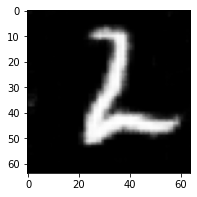

In [63]:
  z = torch.randn((1, z_size, 1, 1)).to(device)
  fake_img = G(z)
  fake_img = fake_img[0]
  fake_img = fake_img.detach().cpu().reshape((64,64))
  fig = plt.figure(figsize = (3,3)) 
  ax = fig.add_subplot(111)
  ax.imshow(fake_img, cmap='gray') 

In [64]:
def show_gan_loss(loss):
  fig, ax = plt.subplots()
  d_losses = np.array(loss)
  g_losses = np.array(loss)
  plt.plot(d_losses, label='Discriminator')
  plt.plot(g_losses, label='Generator')
  plt.title("Training Losses")
  plt.legend()

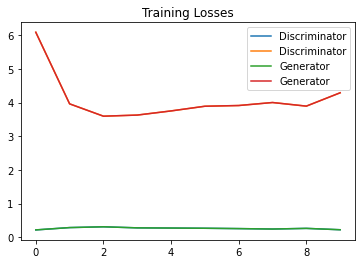

In [65]:
show_gan_loss(mnist_gan_losses)

In [71]:
def show_interpolation(inters):
  for i in inters:
    i = i.detach().cpu().reshape((64,64))
    fig = plt.figure(figsize = (3,3)) 
    ax = fig.add_subplot(111)
    ax.imshow(i, cmap='gray') 

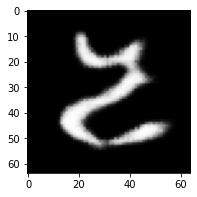

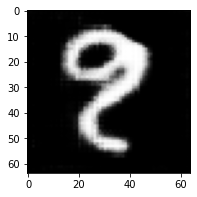

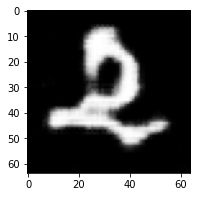

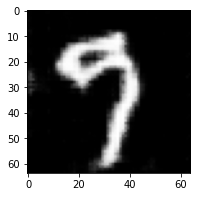

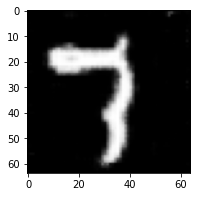

In [72]:
show_interpolation(minist_gan_inters)